In this notebook, we replicate the corrected versions of select figures from Muchlinski et al. (2016). All but Figure 3 have code provided for the corrected figures, which we copied and ran in the cells below. We save Fig 3 to the end so we can include a detailed description of how we generated a "corrected" version of that figure. 

You can skip to the headers beginning with "Figure 2", "Figure 1", "Table 1", and "Figure 3" to verify each figure.

In [1]:
library(randomForest)
library(caret)
library(ROCR)
library(pROC)
library(stepPlr)
library(doMC)
library(xtable)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



## Load data

In [2]:
data <- read.csv(file="./data/SambanisImp.csv")

In [3]:
# Using only the 88 variables specified in Sambanis (2006) Appendix
data.full <- data[,
    c("warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
      "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
      "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
      "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
      "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
      "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
      "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
      "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
      "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
      "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
      "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
      "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
      "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
      "warhist", "xconst")]

In [4]:
# Convert DV into Factor with names 
data.full$warstds <- factor(
    data.full$warstds,
    levels=c(0,1),
    labels=c("peace", "war"))

## Train models

In [5]:
# distribute workload over multiple cores for faster computation
registerDoMC(cores=7)
set.seed(666)

In [6]:
# cross-validation function for the Caret Library
tc <- trainControl(method="cv",
    number=10,
    summaryFunction=twoClassSummary,
    classProb=T,
    savePredictions=T)

### Fearon and Laitin Model (2003)

In [7]:
model.fl.1 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=data.full)

In [8]:
summary(model.fl.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0635  -0.1859  -0.1325  -0.0994   3.2962  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.46582    1.11539  -7.590 3.20e-14 ***
warhist      0.02247    0.25379   0.089  0.92946    
ln_gdpen    -0.35196    0.11791  -2.985  0.00284 ** 
lpopns       0.18788    0.06815   2.757  0.00584 ** 
lmtnest      0.18706    0.08049   2.324  0.02013 *  
ncontig      0.26477    0.28232   0.938  0.34831    
oil          0.33689    0.30155   1.117  0.26391    
nwstate      1.86032    0.32037   5.807 6.37e-09 ***
inst3        1.36212    0.20709   6.577 4.79e-11 ***
pol4        -0.02435    0.01781  -1.367  0.17170    
ef           0.44421    0.42340   1.049  0.29411    
relfrac      0.59413    0.50782   1.170  0.24202    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1185.9  on 7139  degrees 

### Fearon and Laitin Model (2003) penalized logistic regression

In [9]:
model.fl.2 <- train(
    as.factor(warstds)~warhist+ln_gdpen+lpopns+lmtnest+ncontig+oil+nwstate
                      +inst3+pol4+ef+relfrac, #FL 2003 model spec
    metric="ROC", method="plr",
    trControl=tc, data=data.full)

In [10]:
summary(model.fl.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  8.42662   1.10833   7.603    0.000
warhist   -0.01827   0.25031  -0.073    0.942
ln_gdpen   0.35579   0.11704   3.040    0.002
lpopns    -0.18719   0.06783  -2.760    0.006
lmtnest   -0.18629   0.08026  -2.321    0.020
ncontig   -0.26372   0.27765  -0.950    0.342
oil       -0.33176   0.29554  -1.123    0.261
nwstate   -1.82097   0.31626  -5.758    0.000
inst3     -1.34669   0.20509  -6.566    0.000
pol4       0.02400   0.01774   1.353    0.176
ef        -0.43870   0.40566  -1.081    0.280
relfrac   -0.57091   0.48055  -1.188    0.235

    Null deviance: 1185.92 on 7139 degrees of freedom
Residual deviance: 1057.21 on 7128.16 degrees of freedom
            Score: deviance + 8.9 * df = 1162.24 


### Collier and Hoeffler Model (2004) 


In [11]:
model.ch.1 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=data.full)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [12]:
summary(model.ch.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1130  -0.1837  -0.1161  -0.0777   3.5875  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -6.945e+00  1.251e+00  -5.550 2.86e-08 ***
sxpnew       1.768e+01  4.288e+00   4.123 3.74e-05 ***
sxpsq       -7.685e+01  1.125e+01  -6.831 8.42e-12 ***
ln_gdpen    -4.402e-01  1.418e-01  -3.104  0.00191 ** 
gdpgrowth   -6.783e+00  1.228e+00  -5.525 3.29e-08 ***
warhist     -5.266e-01  2.612e-01  -2.016  0.04378 *  
lmtnest      2.332e-01  8.192e-02   2.846  0.00443 ** 
ef          -1.118e-02  4.446e-01  -0.025  0.97993    
popdense    -1.463e-04  9.093e-04  -0.161  0.87217    
lpopns       2.265e-01  6.922e-02   3.272  0.00107 ** 
coldwar     -1.081e-01  2.678e-01  -0.404  0.68642    
seceduc     -5.562e-03  5.650e-03  -0.984  0.32490    
ptime       -2.279e-03  7.607e-04  -2.996  0.00273 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter

### Collier and Hoeffler (2004) penalized logistic regression

In [13]:
model.ch.2 <- train(
    as.factor(warstds)~sxpnew+sxpsq+ln_gdpen+gdpgrowth+warhist+lmtnest+ef+popdense
                      +lpopns+coldwar+seceduc+ptime,
    metric="ROC", method="plr",
    trControl=tc, data=data.full)


Convergence warning in plr: 2 


In [14]:
summary(model.ch.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  5.69042   1.19736   4.752    0.000
sxpnew     6.67340   4.99964   1.335    0.182
sxpsq      4.92896  11.66979   0.422    0.673
ln_gdpen   0.39857   0.12910   3.087    0.002
gdpgrowth  6.77561   1.21447   5.579    0.000
warhist    0.18392   0.26007   0.707    0.480
lmtnest   -0.17193   0.07845  -2.192    0.028
ef        -0.31249   0.43698  -0.715    0.475
popdense   0.00108   0.00116   0.931    0.352
lpopns    -0.18365   0.06734  -2.727    0.006
coldwar   -0.03555   0.26632  -0.133    0.894
seceduc    0.00822   0.00557   1.476    0.140
ptime      0.00118   0.00073   1.616    0.106

    Null deviance: 1185.92 on 7139 degrees of freedom
Residual deviance: 1048.64 on 7127 degrees of freedom
            Score: deviance + 8.9 * df = 1163.99 


### Hegre and Sambanis (2006) Model 

In [15]:
model.hs.1 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="glm", family="binomial",
    trControl=tc, data=data.full)

In [16]:
summary(model.hs.1)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3271  -0.1876  -0.1212  -0.0719   3.7643  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.882e+00  1.336e+00  -5.901 3.62e-09 ***
lpopns       2.314e-01  7.381e-02   3.135  0.00172 ** 
ln_gdpen    -2.978e-01  1.318e-01  -2.259  0.02386 *  
inst3        1.410e+00  2.476e-01   5.694 1.24e-08 ***
parreg      -2.933e-01  1.364e-01  -2.151  0.03151 *  
geo34       -1.062e-01  3.163e-01  -0.336  0.73709    
proxregc    -9.256e-01  3.118e-01  -2.968  0.00300 ** 
gdpgrowth   -6.224e+00  1.209e+00  -5.148 2.63e-07 ***
anoc         4.359e-01  3.037e-01   1.435  0.15119    
partfree     9.320e-02  2.734e-01   0.341  0.73315    
nat_war      1.000e+00  3.119e-01   3.206  0.00134 ** 
lmtnest      1.652e-01  7.996e-02   2.066  0.03883 *  
decade1      1.870e-01  2.563e-01   0.729  0.46574    
pol4sq       2.510e-03  5.606e-03   0.448  0.65428    
nwstate      1.872e+00  3.526e-01 

### Hegre and Sambanis (2006) penalized logistic regression

In [17]:
model.hs.2 <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
           +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
           +geo1+tnatwar+presi,
    metric="ROC", method="plr",
    trControl=tc, data=data.full)


Convergence warning in plr: 2 


In [18]:
summary(model.hs.2)


Call:
stepPlr::plr(x = x, y = y, weights = if (!is.null(wts)) wts else rep(1, 
    length(y)), lambda = param$lambda, cp = as.character(param$cp))

Coefficients:
          Estimate Std.Error z value Pr(>|z|)
Intercept  6.68751   1.31047   5.103    0.000
lpopns    -0.17152   0.07319  -2.343    0.019
ln_gdpen   0.30106   0.13110   2.296    0.022
inst3     -1.41477   0.24655  -5.738    0.000
parreg     0.33586   0.13389   2.508    0.012
geo34      0.11543   0.31329   0.368    0.713
proxregc   0.92051   0.30956   2.974    0.003
gdpgrowth  5.30115   1.25502   4.224    0.000
anoc      -0.37100   0.30178  -1.229    0.219
partfree  -0.06924   0.27214  -0.254    0.799
nat_war   -1.00776   0.31103  -3.240    0.001
lmtnest   -0.16578   0.07927  -2.091    0.037
decade1   -0.16346   0.25583  -0.639    0.523
pol4sq    -0.00173   0.00558  -0.310    0.757
nwstate   -1.85961   0.34976  -5.317    0.000
regd4_alt  0.05579   0.02847   1.960    0.050
etdo4590  -0.00063   0.22750  -0.003    0.998
milper   

### Random Forest

In [32]:
model.rf <- train(
    as.factor(warstds)~.,
    metric="ROC", method="rf",
    sampsize=c(30,90),
    importance=T,
    proximity=F, 
    ntree=1000,
    trControl=tc, data=data.full)

In [33]:
summary(model.rf)

                Length Class      Mode     
call                8  -none-     call     
type                1  -none-     character
predicted        7140  factor     numeric  
err.rate         3000  -none-     numeric  
confusion           6  -none-     numeric  
votes           14280  matrix     numeric  
oob.times        7140  -none-     numeric  
classes             2  -none-     character
importance        360  -none-     numeric  
importanceSD      270  -none-     numeric  
localImportance     0  -none-     NULL     
proximity           0  -none-     NULL     
ntree               1  -none-     numeric  
mtry                1  -none-     numeric  
forest             14  -none-     list     
y                7140  factor     numeric  
test                0  -none-     NULL     
inbag               0  -none-     NULL     
xNames             90  -none-     character
problemType         1  -none-     character
tuneValue           1  data.frame list     
obsLevels           2  -none-   

### EXTENSION: computing F1 score for the models trained according to Muchlinski et al.'s specifications 
Note we did not do this for all models, just a subset of them to make a comparison with Fig 3 in the end

In [54]:
confMat <- function(threshold=0.5, pred, obs){
    if(class(obs)=="factor") obs <- as.numeric(obs)-1

    uMat <- matrix(threshold,length(obs),length(threshold),byrow=T)
    preds <- c(pred)-uMat > 0
    TP <- t(obs)%*%preds
    FP <- t(1-obs)%*%preds
    TN <- t(1-obs)%*%(1-preds)
    FN <- t(obs)%*%(1-preds)

    cmMat <- cbind(c(TP),c(FP),c(TN),c(FN))
    colnames(cmMat) <- c("tp","fp","tn","fn")
    cmMat <- data.frame(cmMat)
    return(cmMat)
}

compute_F1 <- function(model, test) {
    predictions <- predict(model, newdata=test, type="prob")
    confusion <- confMat(pred=predictions[,2], obs=test[,1])
    F1 <- 2*confusion$tp / (2*confusion$tp + confusion$fn + confusion$fp)
    return(F1)
}

F1 score for random forest model on all training data (same way the authors create the ROC curves)

In [58]:
compute_F1(model.rf, data.full)

[1] 0.1167002

F1 score for logistic regression models

In [57]:
compute_F1(model.fl.1, data.full)

[1] 0.01709402

In [59]:
compute_F1(model.ch.1, data.full)

[1] 0

In [60]:
compute_F1(model.hs.1, data.full)

[1] 0.01680672

## Figure 2 (ROC Curves)

In [212]:
pred.FL.war <- model.fl.1$finalModel$fitted.values
pred.CH.war <- model.ch.1$finalModel$fitted.values
pred.HR.war <- model.hs.1$finalModel$fitted.values

In [213]:
RF.1.pred <- predict(model.rf$finalModel, type="prob")
RF.1.pred <- as.data.frame(RF.1.pred)

In [214]:
pred.FL <- prediction(pred.FL.war, data.full$warstds)
perf.FL <- performance(pred.FL,"tpr","fpr")
pred.CH <- prediction(pred.CH.war, data.full$warstds)
perf.CH <- performance(pred.CH,"tpr","fpr")
pred.HS <- prediction(pred.HR.war, data.full$warstds)
perf.HS <- performance(pred.HS, "tpr", "fpr")
pred.RF.1 <- prediction(RF.1.pred$war, data.full$warstds)
perf.RF.1 <- performance(pred.RF.1, "tpr", "fpr")

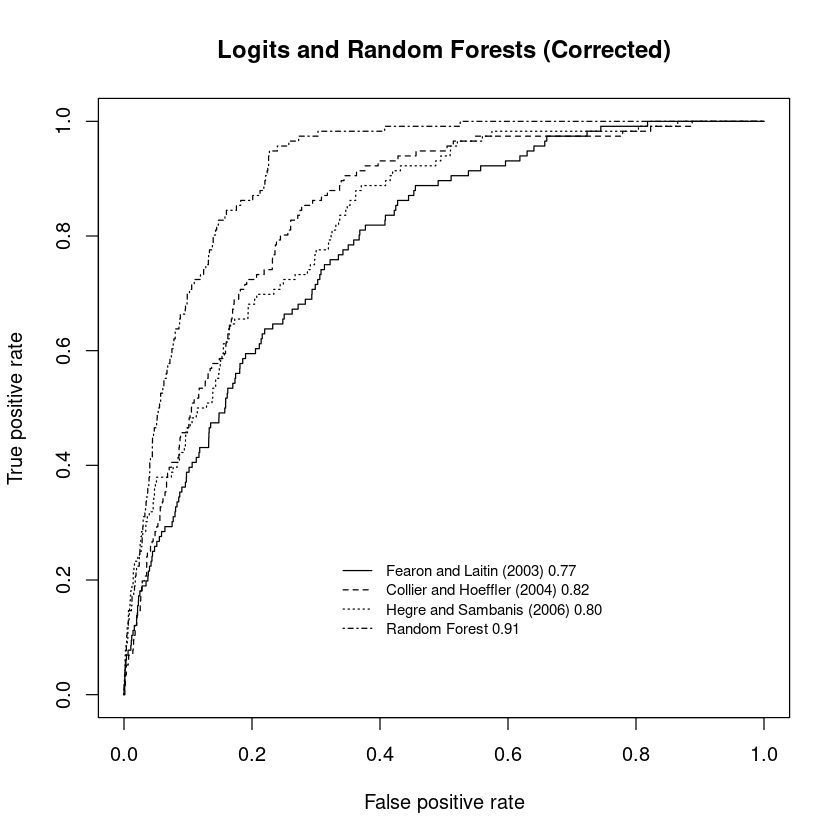

In [215]:
plot(perf.FL, main="Logits and Random Forests (Corrected)")
plot(perf.CH, add=T, lty=2)
plot(perf.HS, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.82",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)

In [216]:
FL.2.pred <- 1-model.fl.2$finalModel$fitted.values
CH.2.pred <- 1-model.ch.2$finalModel$fitted.values
HS.2.pred <- 1-model.hs.2$finalModel$fitted.values

In [217]:
pred.FL.2 <- prediction(FL.2.pred, data.full$warstds)
perf.FL.2 <- performance(pred.FL.2,"tpr","fpr")
pred.CH.2 <- prediction(CH.2.pred, data.full$warstds)
perf.CH.2 <- performance(pred.CH.2,"tpr","fpr")
pred.HS.2 <- prediction(HS.2.pred, data.full$warstds)
perf.HS.2 <- performance(pred.HS.2,"tpr","fpr")

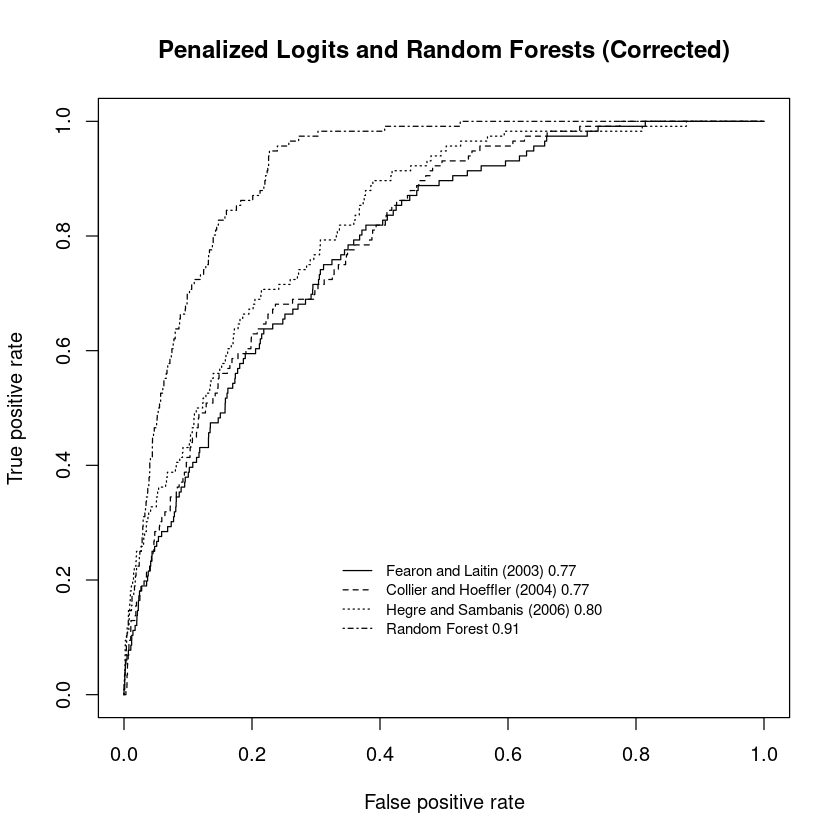

In [218]:
plot(perf.FL.2, main="Penalized Logits and Random Forests (Corrected)")
plot(perf.CH.2, add=T, lty=2)
plot(perf.HS.2, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77",
         "Collier and Hoeffler (2004) 0.77",
         "Hegre and Sambanis (2006) 0.80",
         "Random Forest 0.91" ), 
       lty=c(1,2,3,4), bty="n", cex = .75)

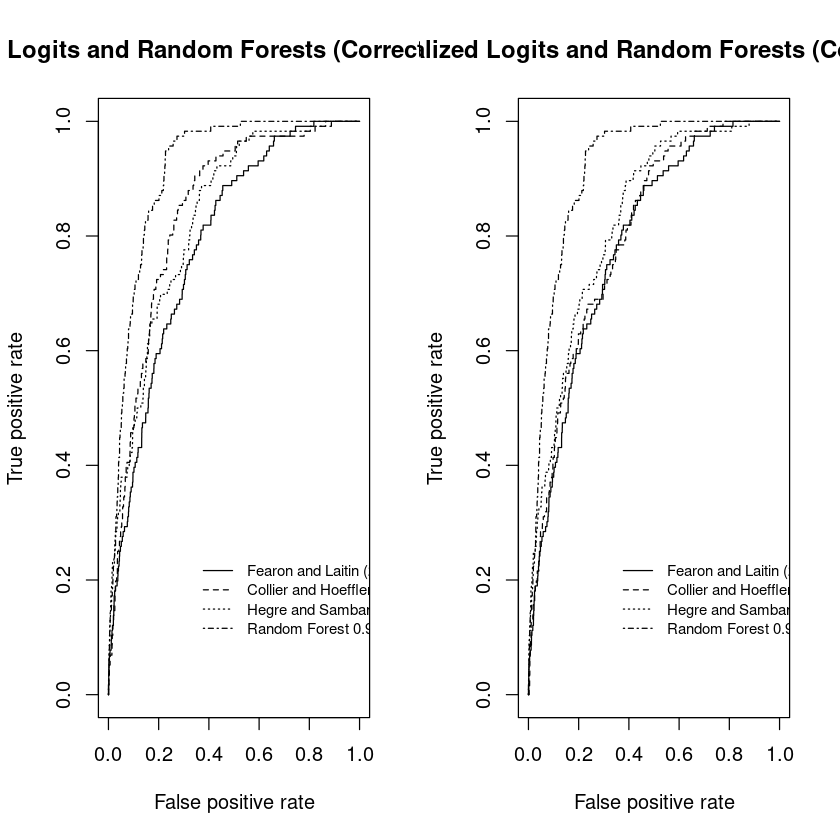

In [219]:
### Combine both ROC plots
par(mfrow=c(1,2))
plot(perf.FL, main="Logits and Random Forests (Corrected)")
plot(perf.CH, add=T, lty=2)
plot(perf.HS, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25, 
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.82",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)
plot(perf.FL.2, main="Penalized Logits and Random Forests (Corrected)")
plot(perf.CH.2, add=T, lty=2)
plot(perf.HS.2, add=T, lty=3)
plot(perf.RF.1, add=T, lty=4)
legend(0.32, 0.25,
       c("Fearon and Laitin (2003) 0.77", "Collier and Hoeffler (2004) 0.77",
         "Hegre and Sambanis (2006) 0.80", "Random Forest 0.91" ),
       lty=c(1,2,3,4), bty="n", cex = .75)

## Figure 1 (separation plots)

In [29]:
library(separationplot)

Loading required package: RColorBrewer

Loading required package: Hmisc

Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster


Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:xtable’:

    label, label<-


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: MASS

Loading required package: foreign



Transform DV back to 0,1 values for separation plots

In [30]:
data.full$warstds <- factor(
    data.full$warstds,
    levels=c("peace","war"),
    labels=c(0, 1))

Transform actual observations into vector for separation plots

In [31]:
Warstds <- as.vector(data.full$warstds)

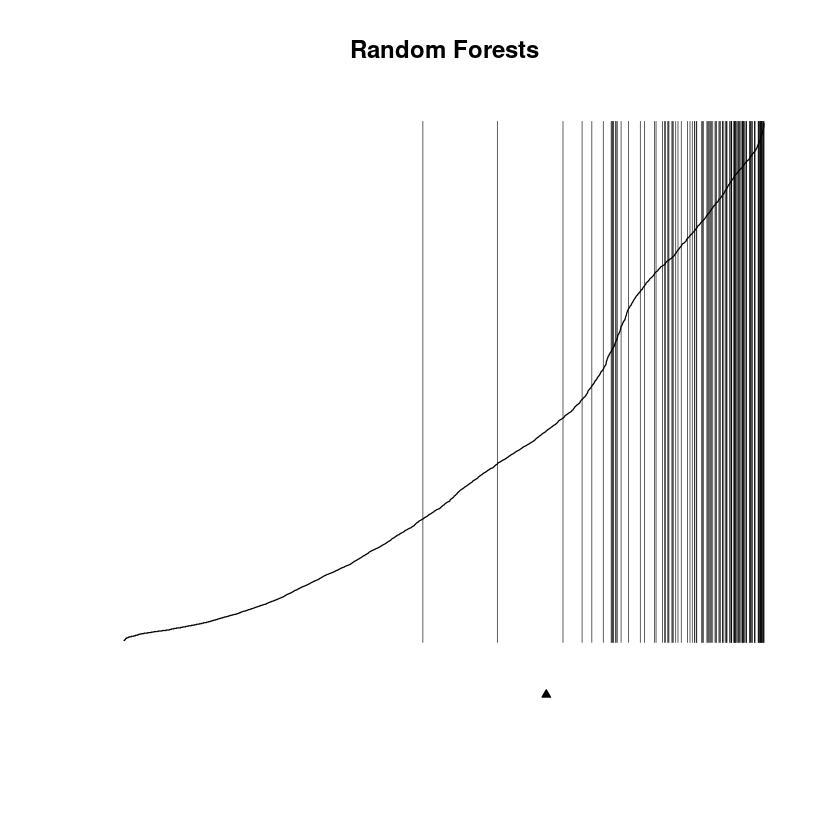

In [32]:
separationplot(
    RF.1.pred$war,
    Warstds,
    type="line",
    line=T,
    lwd2=1,
    show.expected=T,
    heading="Random Forests", height=2.5, col0="white", col1="black", newplot=F)

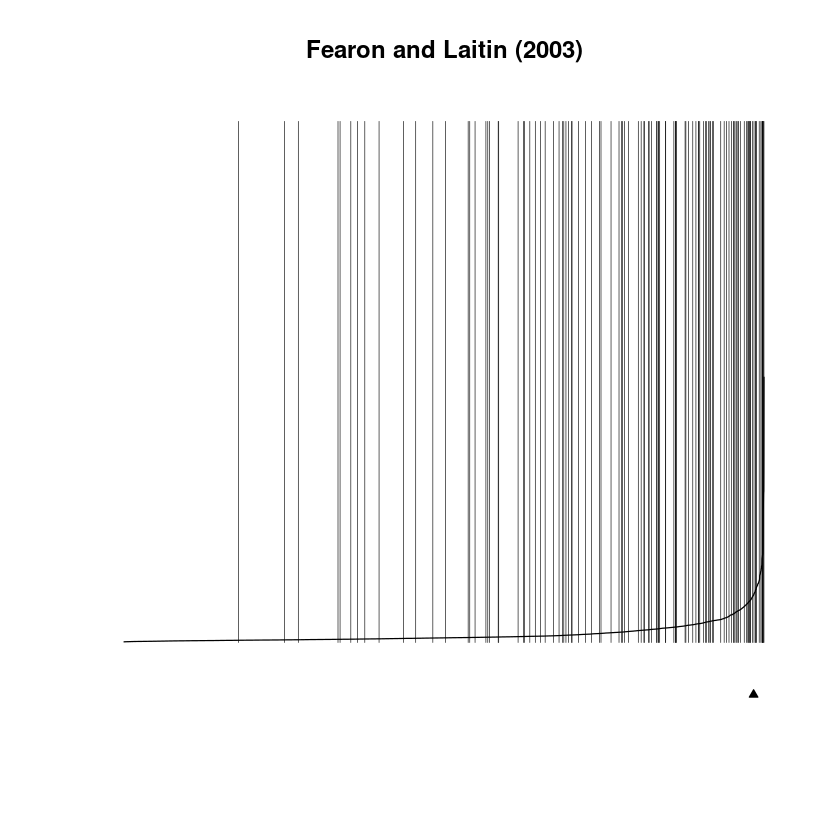

In [33]:
separationplot(
    pred.FL.war, Warstds, type="line", line=T, lwd2=1, show.expected=T,
    heading="Fearon and Laitin (2003)", height=2.5, col0="white", col1="black", newplot=F)

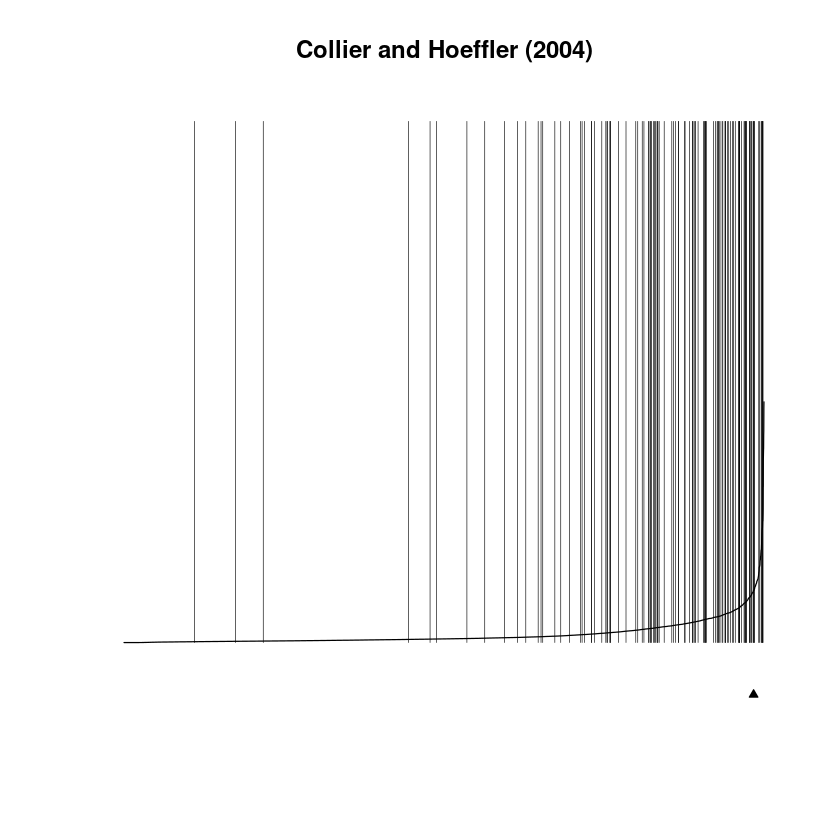

In [34]:
separationplot(
    pred.CH.war, Warstds, type="line", line=T, lwd2=1, show.expected=T,
    heading="Collier and Hoeffler (2004)", height=2.5, col0="white", col1="black", newplot=F)

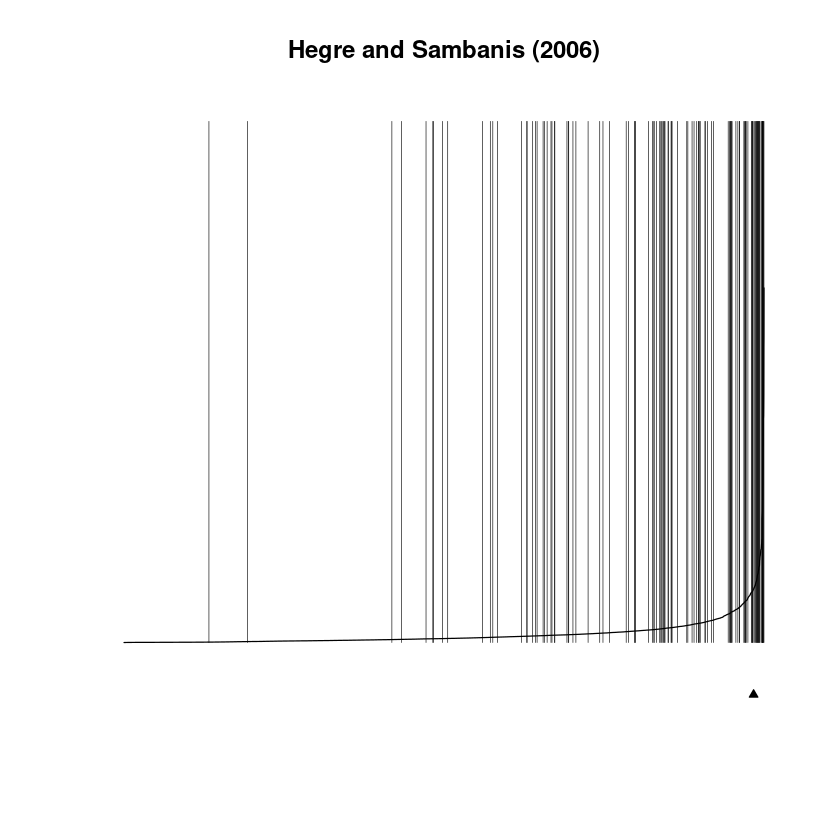

In [35]:
separationplot(
    pred.HR.war, Warstds, type="line", line=T, lwd2=1, show.expected=T,
    heading="Hegre and Sambanis (2006)", height=2.5, col0="white", col1="black", newplot=F)

## Table 1

In [36]:
set.seed(425)
data_imp <- read.csv(file="./data/data_full.csv")
rf.imp <- rfImpute(data_imp, as.factor(data_imp$warstds), iter=5, ntree=1000)

ntree      OOB      1      2
 1000:   0.02%  0.00%  1.48%
ntree      OOB      1      2
 1000:   0.02%  0.00%  1.48%
ntree      OOB      1      2
 1000:   0.04%  0.00%  2.22%
ntree      OOB      1      2
 1000:   0.06%  0.00%  3.70%
ntree      OOB      1      2
 1000:   0.01%  0.00%  0.74%


In [37]:
mena <- subset(rf.imp, rf.imp$year > 2000)

In [38]:
fl.pred <- predict(model.fl.1, newdata=mena, type="prob")
fl.pred <- as.data.frame(fl.pred)
pred.FL.1 <- prediction(fl.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.FL.1 <- performance(pred.FL.1, "auc")

ch.pred <- predict(model.ch.1, newdata=mena, type="prob")
ch.pred <- as.data.frame(ch.pred)
pred.CH.1 <- prediction(ch.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.CH.1 <- performance(pred.CH.1, "auc")

hs.pred <- predict(model.hs.1, newdata=mena, type="prob")
hs.pred <- as.data.frame(hs.pred)
pred.HS.1 <- prediction(hs.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.HS.1 <- performance(pred.HS.1, "auc")

rf.pred <- predict(model.rf, newdata=mena, type="prob")
rf.pred <- as.data.frame(rf.pred)
pred.RF.1 <- prediction(rf.pred$war, mena$`as.factor(data_imp$warstds)`)
perf.RF.1 <- performance(pred.RF.1, "tpr", "fpr")
perf.RF.1 <- performance(pred.RF.1, "auc")

In [39]:
predictions <- cbind(
    mena$cowcode, mena$year, mena$warstds,
    fl.pred[,2], ch.pred[,2],
    hs.pred[,2], rf.pred[,2])

In [40]:
colnames(predictions) <- c(
    "COWcode", "year", "CW_Onset",
    "Fearon and Latin (2003)",
    "Collier and Hoeffler (2004)",
    "Hegre and Sambanis (2006)",
    "Random Forest")
predictions <- as.data.frame(predictions)
Onset_table <- predictions[order(-predictions$CW_Onset, predictions$year),]
Onset_table_1thru19 <- head(Onset_table, n=19)
xtable(Onset_table_1thru19)
# uncomment to write this to a CSV
# write.csv(predictions, file="testing_file_CW_onset_RF_rep_final.csv")

,COWcode,year,CW_Onset,Fearon and Latin (2003),Collier and Hoeffler (2004),Hegre and Sambanis (2006),Random Forest
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
127,438,2001,1,0.007643157,0.004191886,0.006491767,0.070
351,516,2001,1,0.029228931,0.003032128,0.018701560,0.087
365,517,2001,1,0.008109073,0.002871234,0.006613362,0.046
435,540,2001,1,0.012828092,0.011095105,0.016913126,0.713
883,700,2001,1,0.007259153,0.003565428,0.004751861,0.064
296,500,2002,1,0.015394016,0.021599486,0.020239060,0.928
157,450,2003,1,0.016241764,0.037933291,0.026775852,0.981
298,500,2004,1,0.010231514,0.004850783,0.011289025,0.449
704,645,2004,1,0.031794188,0.005469389,0.027515971,0.162


## Figure 3

Figure 3 in particular is highly underspecified. Because the goal of assignment 2 is to reproduce **corrected** figures from the paper, we decided our goal in reproducing Figure 3 is to make the adjustments we think the authors would have made to address the comments from other papers. 

In particular, we took the results from [Neunhoeffer & Sternberg (2019)](https://www.cambridge.org/core/journals/political-analysis/article/how-crossvalidation-can-go-wrong-and-what-to-do-about-it/CA8C4B470E27C99892AB978CE0A3AE29/core-reader) as a reference for how we might correct Muchlinski et al.'s setup and what the average F1 score will likely be after making those adjustments. One footnote included in Neunhoeffer & Sternberg's paper:

"Note that most of the 𝐹1 scores we calculated are substantially smaller than the 𝐹1 scores reported by Muchlinski et al. (2016, 97). Unfortunately we could not find code or data to replicate Figure 3 in the original paper. However, since Muchlinski et al. (2016, 96) note that “[a]ll logistic regression models fail to specify any civil war onset in the out-of-sample data,” the 𝐹1 scores should be close to 0 ."

In [185]:
# same functions as the EXTENSION note above
confMat <- function(threshold=0.5, pred, obs){
    if(class(obs)=="factor") obs <- as.numeric(obs)-1

    uMat <- matrix(threshold,length(obs),length(threshold),byrow=T)
    preds <- c(pred)-uMat > 0
    TP <- t(obs)%*%preds
    FP <- t(1-obs)%*%preds
    TN <- t(1-obs)%*%(1-preds)
    FN <- t(obs)%*%(1-preds)

    cmMat <- cbind(c(TP),c(FP),c(TN),c(FN))
    colnames(cmMat) <- c("tp","fp","tn","fn")
    cmMat <- data.frame(cmMat)
    return(cmMat)
}

In [61]:
compute_F1 <- function(model, test) {
    predictions <- predict(model, newdata=test, type="prob")
    confusion <- confMat(pred=predictions[,2], obs=test[,1])
    F1 <- 2*confusion$tp / (2*confusion$tp + confusion$fn + confusion$fp)
    return(F1)
}

We adjusted the setup in Neunhoeffer & Sternberg slightly: they evaluate on out-of-sample data where the data is divided into pre-1989 (training) and post-1989 (out-of-sample testing). Because Muchlinski et al. does not specify this kind of split in the code for Figs 1 and 2, and the manuscript also doesn't seem to suggest that Fig 3 was evaluated on out-of-sample data, we do not make the split here. 
 
Some notes for the code below:
- We collect the F1 scores over `p = [0.2, 0.4, 0.6, 0.8] * nrow(data.full)` training samples
- For each `p`, we always test on 10% of `data.full`, where the available training and testing data is selected through 10-fold stratified cross-validation (as described in Neunhoeffer & Sternberg).
- All RF, logistic regression, and L1-regularized logistic regression models are evaluated over the same 10 folds (i.e. same training and testing data). 
- For the logistic regression model, we chose to use the Hegre and Sambanis (2006) model, but results are similar for the other models cited in Muchlinski et. al's paper.

In [64]:
training_df <- data.full

# Create folds for 10-fold cross-validation
nrFolds <- 10
# We use stratified cross-validation (to have similar distributions of 1s and 0s)
folds <- rep(NA, nrow(training_df))

folds[training_df[,1]=="peace"] <-
  rep_len(1:nrFolds,
          sum(training_df[,1]=="peace"))[sample(sum(training_df[,1]=="peace"),
                                                sum(training_df[,1]=="peace"))]

folds[training_df[,1]=="war"] <-
  rep_len(1:nrFolds,
          sum(training_df[,1]=="war"))[sample(sum(training_df[,1]=="war"),
                                              sum(training_df[,1]=="war"))]

In [65]:
prop <- list(0.2, 0.4, 0.6, 0.8)
tc.rf <- trainControl(
            method="none",
            summaryFunction=twoClassSummary,
            classProb=T, savePredictions=T)

In [66]:
f1_df <- NULL

for(p in prop) {
    print(p)
    n_samples <- p * nrow(training_df)
    rf_F1 <- NULL  # random forest 
    lr_F1 <- NULL  # logistic regression 
    l1_lr_F1 <- NULL  # L1-regularized logistic regression 
    for(k in 1:nrFolds) {
        fold <- which(folds == k)
        
        tsamples <- sample(nrow(training_df[-fold,]), n_samples)
        cv_train <- training_df[-fold,][tsamples,]
        cv_test <- training_df[fold,]
        
        rf_cv <- train(
            as.factor(warstds)~.,
            method="rf", 
            metric="ROC", 
            # note the update to `sampsize` to balance the war and peace samples, 
            # this is an adjustment made in Neunhoeffer & Sternberg (2019) 
            sampsize=c(sum(cv_train[,1]=="war"),
                       sum(cv_train[,1]=="war")),
            importance=T, proximity=F, ntree=1000,
            trControl=tc.rf, data=cv_train)
        rf_F1 <- c(rf_F1, compute_F1(rf_cv, cv_test))
        
        # we chose the Hegre and Sambanis (2006) logreg model, but results are
        # similar for the other logreg models cited in the paper
        lr_cv <- train(
            warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
               +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
               +geo1+tnatwar+presi,
            metric="ROC", method="glm", family="binomial", 
            trControl=tc, data=cv_train)
        lr_F1 <- c(lr_F1, compute_F1(lr_cv, cv_test))
        
        l1_lr_cv <- train(
            warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
               +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
               +geo1+tnatwar+presi,
            metric="ROC", 
            method="regLogistic",
            tuneGrid=expand.grid(loss='L1', epsilon=c(0.001, 0.01, 0.1), cost=c(0.5, 1.0, 2.0)),
            trControl=tc, 
            data=cv_train)
        l1_lr_F1 <- c(l1_lr_F1, compute_F1(l1_lr_cv, cv_test))
    }
    print(mean(rf_F1, na.rm = T))
    print(mean(lr_F1, na.rm = T))
    print(mean(l1_lr_F1, na.rm = T))
    
    f1_df <- rbind(f1_df, data.frame(Model="RF", F1=rf_F1, Training_prop=p))
    f1_df <- rbind(f1_df, data.frame(Model="Logreg", F1=lr_F1, Training_prop=p))
    f1_df <- rbind(f1_df, data.frame(Model="L1_Logreg", F1=l1_lr_F1, Training_prop=p))
}

[1] 0.2


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 0.1610031
[1] 0.01538462
[1] 0
[1] 0.4


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 0.1533779
[1] 0.02967033
[1] 0
[1] 0.6


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 0.1694253
[1] 0.01333333
[1] 0.01538462
[1] 0.8


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 0.1764667
[1] 0.01333333
[1] 0.01428571


In [67]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [68]:
summary_df <- aggregate(x=f1_df$F1, by=list(f1_df$Training_prop, f1_df$Model), FUN=mean)
std_data <- aggregate(x=f1_df$F1, by=list(f1_df$Training_prop, f1_df$Model), FUN=sd)
summary_df$sd <- std_data$x
summary_df

Group.1,Group.2,x,sd
<dbl>,<fct>,<dbl>,<dbl>
0.2,RF,0.16100310,0.03482264
0.4,RF,0.15337793,0.02863705
0.6,RF,0.16942531,0.03172768
0.8,RF,0.17646669,0.02597212
0.2,Logreg,0.01538462,0.04865043
0.4,Logreg,0.02967033,0.06260415
0.6,Logreg,0.01333333,0.04216370
0.8,Logreg,0.01333333,0.04216370
0.2,L1_Logreg,0.00000000,0.00000000


### Figure 3, Random Forest

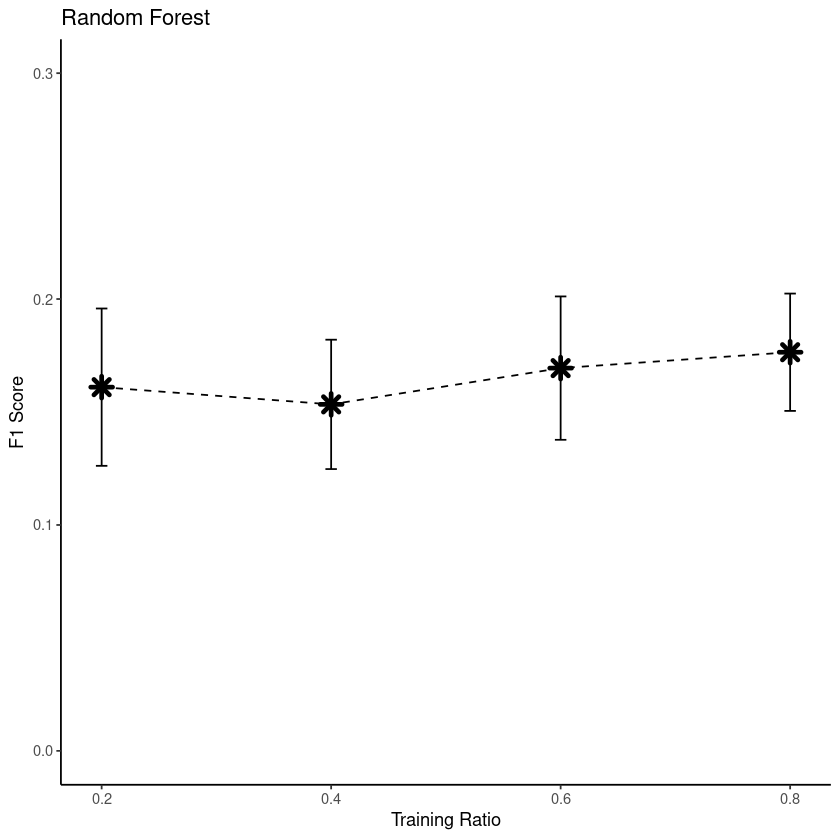

In [69]:
p <- ggplot(summary_df[summary_df$Group.2 == 'RF',], aes(x=Group.1, y=x)) + 
  geom_line(linetype='dashed') +
  geom_point(shape=8, size=3, stroke=2)+
  geom_errorbar(aes(ymin=x-sd, ymax=x+sd), width=.01,
                 position=position_dodge(0.05))
p + labs(title="Random Forest", x="Training Ratio", y = "F1 Score") +
    ylim(0, 0.3) +
    theme_classic() +
    scale_color_manual(values=c('#999999','#E69F00'))

### Figure 3, Logistic Regression

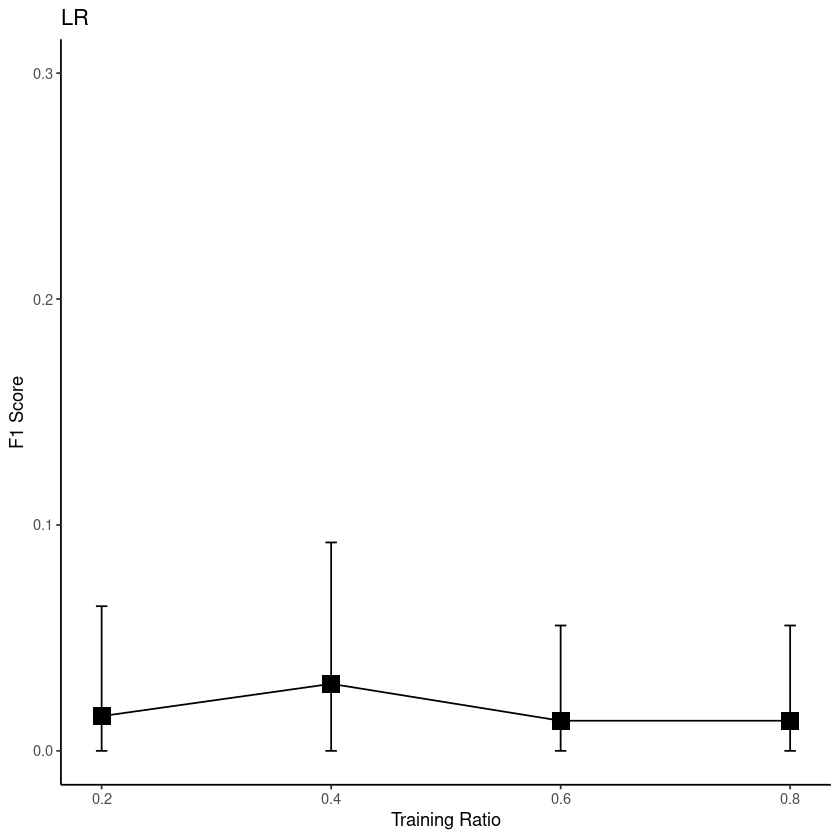

In [70]:
p <- ggplot(summary_df[summary_df$Group.2 == 'Logreg',], aes(x=Group.1, y=x)) + #, group=supp, color=supp)) + 
  geom_line() +
  geom_point(shape=15, size=3, stroke=3)+
  geom_errorbar(aes(ymin=max(0, x-sd), ymax=x+sd), width=.01,
                 position=position_dodge(0.05))
p + labs(title="LR", x="Training Ratio", y = "F1 Score") +
    ylim(0, 0.3) +
    theme_classic() +
    scale_color_manual(values=c('#999999','#E69F00'))

### Figure 3, L1-regularized Logistic Regression

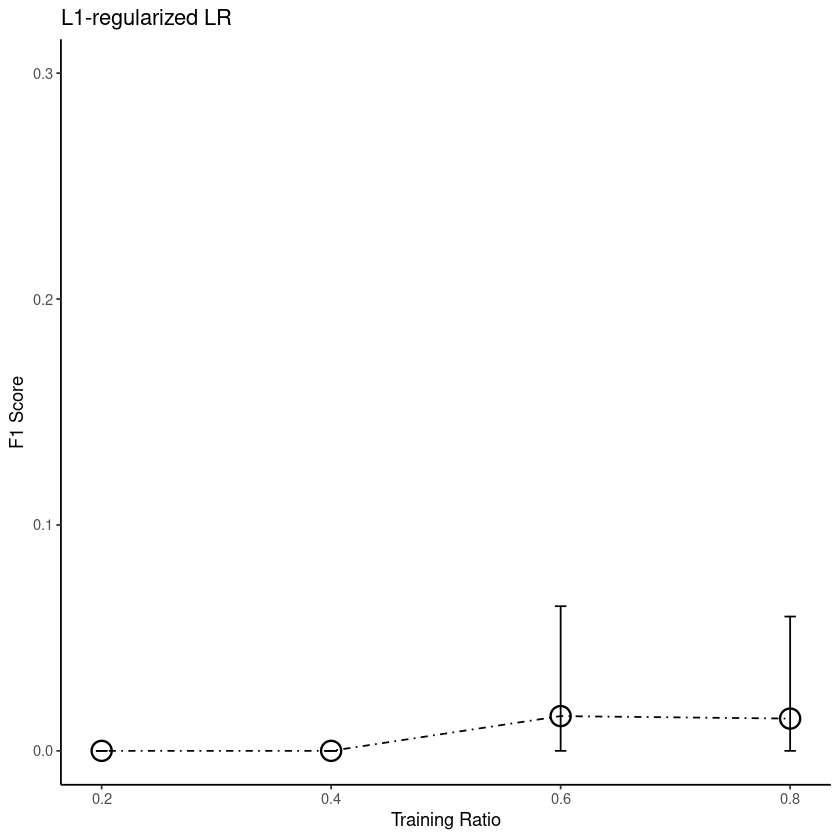

In [71]:
p <- ggplot(summary_df[summary_df$Group.2 == 'L1_Logreg',], aes(x=Group.1, y=x)) + #, group=supp, color=supp)) + 
  geom_line(linetype='dotdash') +
  geom_point(shape=1, size=5, stroke=1)+
  geom_errorbar(aes(ymin=max(0, x-sd), ymax=x+sd), width=.01,
                 position=position_dodge(0.05))
p + labs(title="L1-regularized LR", x="Training Ratio", y = "F1 Score") +
    ylim(0, 0.3) +
    theme_classic() +
    scale_color_manual(values=c('#999999','#E69F00'))

## extra stuff for testing and debugging, will remove soon

In [427]:
rf_cv <- train(
            as.factor(warstds)~.,
            method="rf", 
            metric="ROC", 
            sampsize=c(sum(cv_training[,1]=="war"),
                       sum(cv_training[,1]=="war")),
            importance=T,
            proximity=F, 
            ntree=1000,
            trControl=tc.lr,
            data=cv_training)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Something is wrong; all the ROC metric values are missing:
      ROC           Sens          Spec    
 Min.   : NA   Min.   : NA   Min.   : NA  
 1st Qu.: NA   1st Qu.: NA   1st Qu.: NA  
 Median : NA   Median : NA   Median : NA  
 Mean   :NaN   Mean   :NaN   Mean   :NaN  
 3rd Qu.: NA   3rd Qu.: NA   3rd Qu.: NA  
 Max.   : NA   Max.   : NA   Max.   : NA  
 NA's   :3     NA's   :3     NA's   :3    


ERROR: Error: Stopping


In [425]:
compute_F1(rf_cv, cv_test)

[1] 0.1641791

In [435]:
tmp_tc <- trainControl(
            method="cv",
            number=10,
            summaryFunction=twoClassSummary,
            classProb=T,
            #savePredictions=T,
        )
l1_lr_cv <- train(
            as.factor(warstds)~.,
            metric="ROC", 
            method="regLogistic",
            loss="L1",
            tuneGrid=expand.grid(loss='L1', epsilon=c(0.001, 0.01, 0.1), cost=c(0.5, 1.0, 2.0)),
            trControl=tmp_tc, 
            data=cv_training)

In [436]:
l1_lr_cv

Regularized Logistic Regression 

5712 samples
  90 predictor
   2 classes: 'peace', 'war' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5142, 5141, 5141, 5141, 5141, 5141, ... 
Resampling results across tuning parameters:

  epsilon  cost  ROC        Sens       Spec
  0.001    0.5   0.8064127  1.0000000  0.00
  0.001    1.0   0.8050302  0.9998221  0.01
  0.001    2.0   0.8168542  0.9991091  0.01
  0.010    0.5   0.8097129  1.0000000  0.00
  0.010    1.0   0.8136569  0.9996438  0.01
  0.010    2.0   0.8204242  0.9991091  0.01
  0.100    0.5   0.8135148  1.0000000  0.00
  0.100    1.0   0.8202774  1.0000000  0.01
  0.100    2.0   0.8261772  0.9996435  0.01

Tuning parameter 'loss' was held constant at a value of L1
ROC was used to select the optimal model using the largest value.
The final values used for the model were cost = 2, loss = L1 and epsilon = 0.1.

In [255]:
for(p in prop) {
    F1 <- NULL
    n_samples <- p * nrow(pred_data.full)
    print(p)
    for(k in 1:nIter) {
        tsamples <- sample(nrow(trainIndex), n_samples)
        ptrain <- data.full[trainIndex,][tsamples,]
        
        pr.tc <- trainControl(
            method="cv",
            number=10,
            summaryFunction=twoClassSummary,
            classProb=T,
            #savePredictions=T,
        )
        
        pr.rf <- train(
            as.factor(warstds)~.,
            method="rf", metric="ROC",
            sampsize=c(floor(0.0043*sum(ptrain[,1]=="peace")),
                       floor(0.78*sum(ptrain[,1]=="war"))),
            importance=T,
            proximity=F, 
            ntree=1000,
            trControl=pr.tc,
            data=ptrain
        )
        
        #pr.l1_logreg <- train(
        #    as.factor(warstds)~.,
        #    metric="ROC", method="regLogistic",
        #    trControl=pr.tc,
        #    data=pTrain)

        #pr.logreg <- train(
        #   as.factor(warstds)~., 
        #    metric="ROC", method="glm", family="binomial",
        #    trControl=tc, data=pTrain)
        pr.rf.pred <- predict(pr.rf, newdata=testData, type="prob")
        #confusion <- confMat(pred=pr.rf.pred[,2], obs=testData[,1])
        #tmp_F1 <- 2*confusion$tp / (2*confusion$tp + confusion$fn + confusion$fp)
        tmp_F1 <- F1_Score(y_true=as.numeric(testData[,1])-1, y_pred=ifelse(pr.rf.pred[,2] >= .5, 1, 0))#pr.rf.pred[,2])
        F1 <- c(F1, tmp_F1)
    }
    print(F1)
    print(mean(F1, na.rm = T))
}

[1] 0.2
 [1] 0.7989757 0.5197681 0.8077900 0.7520000 0.8521242 0.7481052 0.7913978
 [8] 0.7702407 0.8191758 0.7729258
[1] 0.7632503
[1] 0.4
 [1] 0.8225941 0.7849741 0.8030625 0.7965812 0.7886354 0.8548190 0.8163094
 [8] 0.7107438 0.7974359 0.8482618
[1] 0.8023417
[1] 0.6
 [1] 0.8222501 0.7986348 0.7613586 0.8138163 0.7505558 0.7536618 0.8003413
 [8] 0.8221013 0.8148148 0.8116554
[1] 0.794919
[1] 0.8
 [1] 0.8192872 0.8222501 0.8153134 0.8222501 0.8178002 0.8237260 0.8173037
 [8] 0.8182963 0.8173037 0.8207705
[1] 0.8194301


In [179]:
F1 <- NULL
ROCAUC <- NULL
PRAUC <-NULL
# actual cross validation
for(k in 1:nrFolds) {
  # actual split of the data
  fold <- which(folds == k)
  cv_training <- training_df[-fold,]
  cv_test <- training_df[fold,]

  rf_cv <- randomForest(warstds~., data = cv_training, ntree = 1000)
  predictions <- predict(rf_cv, newdata = cv_test ,type = "prob")

  confusion <- confMat(pred = predictions[,2], obs = cv_test$warstds)

  tmp_F1 <- 2*confusion$tp / (2*confusion$tp + confusion$fn + confusion$fp)

  F1 <- c(F1, tmp_F1)

  tmp_ROCAUC <- as.numeric(roc(cv_test$warstds, predictions[,2])$auc)

  ROCAUC <- c(ROCAUC, tmp_ROCAUC)

  tmp_PRAUC <- aucPRp(predictions[,2], (as.numeric(cv_test[,1])-1))

  PRAUC <- c(PRAUC, tmp_PRAUC)
}

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases

Setting levels: control = peace, case = war

Setting direction: controls < cases



In [229]:
# Procedure 5 weird MSHK apparent error

F1 <- NULL
ROCAUC <- NULL
PRAUC <-NULL

# Original Code by MSHK just changing data.full to training_df

train_df <- data.full[trainIndex,]

tc <- trainControl(method="cv",
                   number=10,#creates CV folds - 10 for this data
                   summaryFunction=twoClassSummary, # provides ROC summary stats in call to model
                   classProb=T)

model.rf<-train(as.factor(warstds)~.,
                metric="ROC", method="rf",
                sampsize=c(floor(0.0043*sum(trainData[,1]=="peace")),
                           floor(0.78*sum(trainData[,1]=="war"))), #Downsampling the class-imbalanced DV
                importance=T, # Variable importance measures retained
                proximity=F, ntree=1000, # number of trees grown
                trControl=tc, data=trainData)


predictions <- predict(model.rf, newdata=testData, type="prob")

confusion <- confMat(pred=predictions[,2], obs=testData[,1])

tmp_F1 <- 2*confusion$tp / (2*confusion$tp + confusion$fn + confusion$fp)

F1 <- c(F1, tmp_F1)

#tmp_ROCAUC <- as.numeric(roc(train_df[,1], predictions[,2])$auc)

#ROCAUC <- c(ROCAUC, tmp_ROCAUC)

#tmp_PRAUC <- aucPRp(predictions[,2], (as.numeric(train_df[,1])-1))

#PRAUC <- c(PRAUC, tmp_PRAUC)

#res_re <- rbind(res_re, data.frame(Model = "Procedure 5",
#                                   F1 = mean(F1, na.rm = T),
#                                   ROC_AUC = mean(ROCAUC, na.rm = T),
#                                   PR_AUC = mean(PRAUC)))

In [ ]:
#cv_F1 <- F1_Score(factor(ifelse(predictions[,2] > .5, "war", "peace")),
    #                  cv_test[,1],
    #                  positive="war")
    

In [457]:
rf_cv <- train(
    as.factor(warstds)~.,
    method="rf", 
    metric="ROC", 
    sampsize=c(30, 90),
    #sampsize=c(sum(cv_train[,1]=="war"),
    #           sum(cv_train[,1]=="war")),
    importance=T, proximity=F, ntree=1000,
    trControl=tc.rf, data=data.full)
rf_F1 <- c(rf_F1, compute_F1(rf_cv, data.full))

lr_cv <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
       +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
       +geo1+tnatwar+presi,
    metric="ROC", method="glm", family="binomial", 
    trControl=tc, data=data.full)
lr_F1 <- c(lr_F1, compute_F1(lr_cv, data.full))

l1_lr_cv <- train(
    warstds~lpopns+ln_gdpen+inst3+parreg+geo34+proxregc+gdpgrowth+anoc
       +partfree+nat_war+lmtnest+decade1+pol4sq+nwstate+regd4_alt+etdo4590+milper
       +geo1+tnatwar+presi,
    metric="ROC", 
    method="regLogistic",
    tuneGrid=expand.grid(loss='L1', epsilon=c(0.001, 0.01, 0.1), cost=c(0.5, 1.0, 2.0)),
    trControl=tc, 
    data=data.full)
l1_lr_F1 <- c(l1_lr_F1, compute_F1(l1_lr_cv, data.full))

In [461]:
compute_F1(rf_cv, data.full)

[1] 0.1140049

In [462]:
compute_F1(lr_cv, data.full)

[1] 0.01680672

In [460]:
l1_lr_F1

[1] 0.01869159 0.01886792 0.01904762 0.00000000 0.03669725 0.01904762
 [7] 0.01851852 0.01886792 0.01851852 0.01869159 0.01680672